# 再帰型ニューラルネットワーク (RNN) 入門

このノートブックでは、機械学習初心者向けに再帰型ニューラルネットワーク (RNN) の基本概念と実装方法を解説します。

# 本セクションのポイント

- 系列データの文脈保持

ループ構造により、前の時刻の出力（隠れ状態）を次の入力として利用し、時系列や文章などの文脈をモデル化します。 

- 内部メモリでの情報蓄積

隠れ状態として過去の情報を蓄積し、長期間の依存関係（長文テキストや音声）を扱うことが可能です。

- 勾配消失・爆発問題への対策

長い系列では勾配消失・爆発が起こりやすいため、LSTMやGRUといった改良型アーキテクチャが使われます。

## なぜ再帰型ニューラルネットワーク（RNN）が必要なのか？

### 通常のニューラルネットワークの制限

従来の全結合（Fully Connected）ニューラルネットワークには、時系列データを扱う上で重要な制限があります：

1. **入力と出力の長さが固定**: 柔軟な長さの系列データを扱えません
2. **時間的な依存関係を無視**: データの順序情報やコンテキストを考慮できません
3. **パラメータ共有なし**: 異なる位置で同じパターンを検出するために重みを共有できません

例えば、文章「昨日は天気が良かった」を処理する場合、従来のニューラルネットワークでは単語同士の関連性や順序を適切に考慮できません。

### RNNの革新性

RNNは上記の問題を解決するために設計されています：

1. **可変長の入出力を処理可能**: 単語数や時間ステップ数に関わらず柔軟に対応
2. **時間的文脈を保持**: 「内部状態」を通じて過去の情報を記憶し活用
3. **パラメータの共有**: 同じ変換関数を時系列全体で使用し、効率的に学習

これにより、RNNはテキスト、音声、株価、センサーデータなどの順序や時間的文脈が重要なデータを扱うのに適しています。

このノートブックを通じて、RNNの基本原理から実装、そして実際の時系列データ予測までをハンズオン形式で学びましょう。

## ライブラリのインポート

必要なライブラリ（NumPy、TensorFlow、Matplotlib など）をインポートします。

In [ ]:
# 必要なライブラリをインポート
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# バージョン確認
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

# 結果の再現性のために乱数シードを設定
np.random.seed(42)
tf.random.set_seed(42)

## 再帰型ニューラルネットワーク (RNN) の概要

再帰型ニューラルネットワーク（RNN）は、時系列データや順序データを処理するために設計された特殊なニューラルネットワークです。従来のニューラルネットワークとは異なり、RNNは内部状態（メモリ）を持ち、過去の入力情報を記憶して現在の出力に活用することができます。

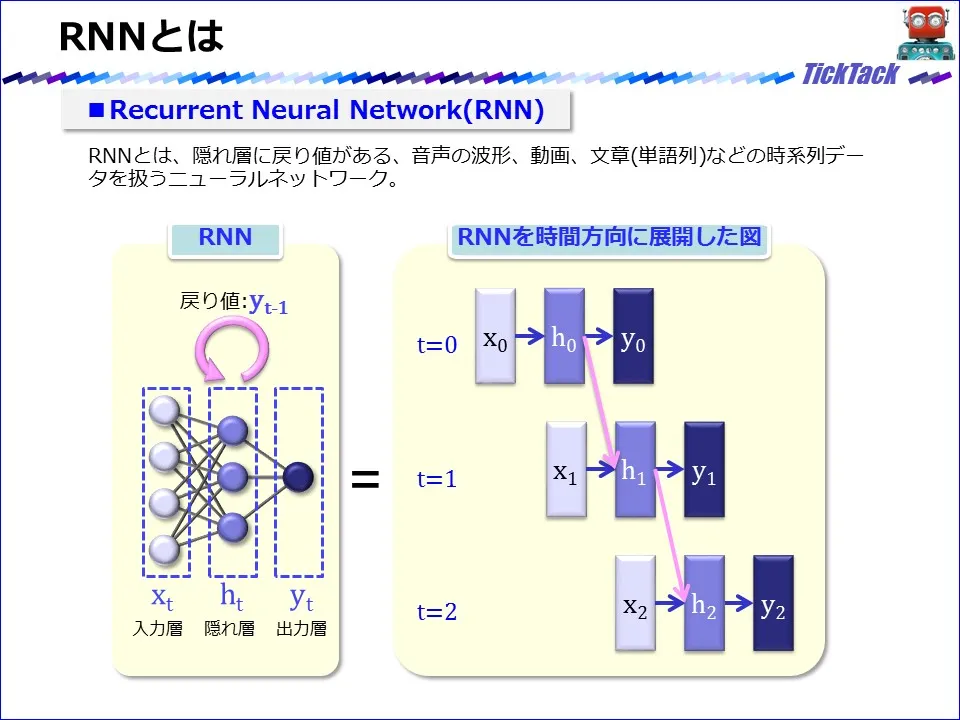

出典: [やさしい深層学習の原理](http://gagbot.net/machine-learning/ml4)

### RNNの主な応用分野:

- **自然言語処理（NLP）**: テキスト生成、機械翻訳、感情分析など
- **時系列予測**: 株価予測、天気予報、需要予測など
- **音声認識**: 音声からテキストへの変換
- **画像のキャプション生成**: 画像の内容を説明する文章の自動生成

RNNの最大の特徴は「記憶」を持つことで、データの前後関係（コンテキスト）を理解できる点にあります。

## RNN の基本構造

RNNの基本構造は、入力層、隠れ層（再帰的な接続を持つ）、出力層から構成されています。

### 数学的表現:

時刻 $t$ における:
- $x_t$: 入力
- $h_t$: 隠れ状態
- $y_t$: 出力
- $W$, $U$, $V$: 重み行列
- $b$, $c$: バイアス項

以下の式で表されます:

$$h_t = \tanh(W \cdot x_t + U \cdot h_{t-1} + b)$$
$$y_t = V \cdot h_t + c$$

### RNNの数式を詳しく理解する

上記の式の各部分を分解して説明します：

1. **隠れ状態の更新式** `$h_t = \tanh(W \cdot x_t + U \cdot h_{t-1} + b)$`
   - `$W \cdot x_t$`: 現在の入力を変換（通常のニューラルネットワークと同様）
   - `$U \cdot h_{t-1}$`: 前の時間ステップの隠れ状態を変換（記憶の部分）
   - `$b$`: バイアス項
   - `$\tanh$`: 活性化関数（-1から1の間に出力を収める）

2. **出力の計算式** `$y_t = V \cdot h_t + c$`
   - `$V \cdot h_t$`: 現在の隠れ状態を出力空間に変換
   - `$c$`: 出力のバイアス項

この計算の流れにより、RNNは時間的な文脈を維持しながら予測を行うことができます。前の時間ステップの情報（$h_{t-1}$）を常に考慮するため、時系列データの処理に適しています。

### 図式表現:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
import sys
import matplotlib.font_manager as fm

# Check if running on Linux
if sys.platform.startswith('linux'):
    # List available fonts with Japanese support
    fonts = [f for f in fm.findSystemFonts() if 'gothic' in f.lower() or 'mincho' in f.lower() or 'meiryo' in f.lower()]
    
    if fonts:
        # Use the first available Japanese font
        plt.rcParams['font.family'] = fm.FontProperties(fname=fonts[0]).get_name()
    else:
        # Fallback to IPAGothic or another common Japanese font
        plt.rcParams['font.family'] = 'IPAGothic, Noto Sans CJK JP, MS Gothic'
else:
    # On Windows/Mac, use platform-specific fonts
    if sys.platform.startswith('win'):
        plt.rcParams['font.family'] = 'MS Gothic'
    elif sys.platform.startswith('darwin'):
        plt.rcParams['font.family'] = 'AppleGothic'

# Disable font warnings (optional)
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

plt.rcParams['axes.unicode_minus'] = False
japanize_matplotlib.japanize()  # Apply japanize_matplotlib settings

In [ ]:
# RNNの図式表現
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

# RNN構造の図を作成
fig, ax = plt.subplots(figsize=(10, 6))

# 隠れ状態のボックスを描画
h_boxes = []
for i in range(4):
    h_box = Rectangle((i*2, 1), 1, 1, fc='lightblue', ec='black', alpha=0.7)
    ax.add_patch(h_box)
    h_boxes.append(h_box)
    ax.text(i*2 + 0.5, 1.5, f"h{i}", ha='center', va='center', fontsize=14)

# 入力のボックスを描画
for i in range(4):
    x_box = Rectangle((i*2, 0), 1, 0.6, fc='lightgreen', ec='black', alpha=0.7)
    ax.add_patch(x_box)
    ax.text(i*2 + 0.5, 0.3, f"x{i}", ha='center', va='center', fontsize=14)

# 出力のボックスを描画
for i in range(4):
    y_box = Rectangle((i*2, 2.5), 1, 0.6, fc='salmon', ec='black', alpha=0.7)
    ax.add_patch(y_box)
    ax.text(i*2 + 0.5, 2.8, f"y{i}", ha='center', va='center', fontsize=14)

# 接続を描画
for i in range(3):
    # 隠れ状態から次の隠れ状態への接続
    arrow = FancyArrowPatch((i*2 + 1, 1.5), ((i+1)*2, 1.5), 
                          connectionstyle="arc3,rad=0.1", 
                          arrowstyle='->', 
                          mutation_scale=15, 
                          lw=1.5, 
                          color='blue')
    ax.add_patch(arrow)

# 入力から隠れ状態への接続と隠れ状態から出力への接続
for i in range(4):
    # 入力から隠れ状態への接続
    arrow_in = FancyArrowPatch((i*2 + 0.5, 0.6), (i*2 + 0.5, 1), 
                             arrowstyle='->', 
                             mutation_scale=15, 
                             lw=1.5, 
                             color='green')
    ax.add_patch(arrow_in)
    
    # 隠れ状態から出力への接続
    arrow_out = FancyArrowPatch((i*2 + 0.5, 2), (i*2 + 0.5, 2.5), 
                              arrowstyle='->', 
                              mutation_scale=15, 
                              lw=1.5, 
                              color='red')
    ax.add_patch(arrow_out)

ax.set_xlim(-0.5, 8.5)
ax.set_ylim(-0.5, 3.5)
ax.set_title('RNNの基本構造', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## サンプルデータの準備

RNNモデルをテストするために、簡単な時系列データを生成します。ここでは、正弦波のデータを作成し、そのパターンを学習させることを目標とします。

### 時系列データとRNNのための前処理方法

時系列データをRNNで扱うには、特定のフォーマットに変換する必要があります。一般的な手法は「スライディングウィンドウ」（時間窓）アプローチです。

**スライディングウィンドウの考え方:**

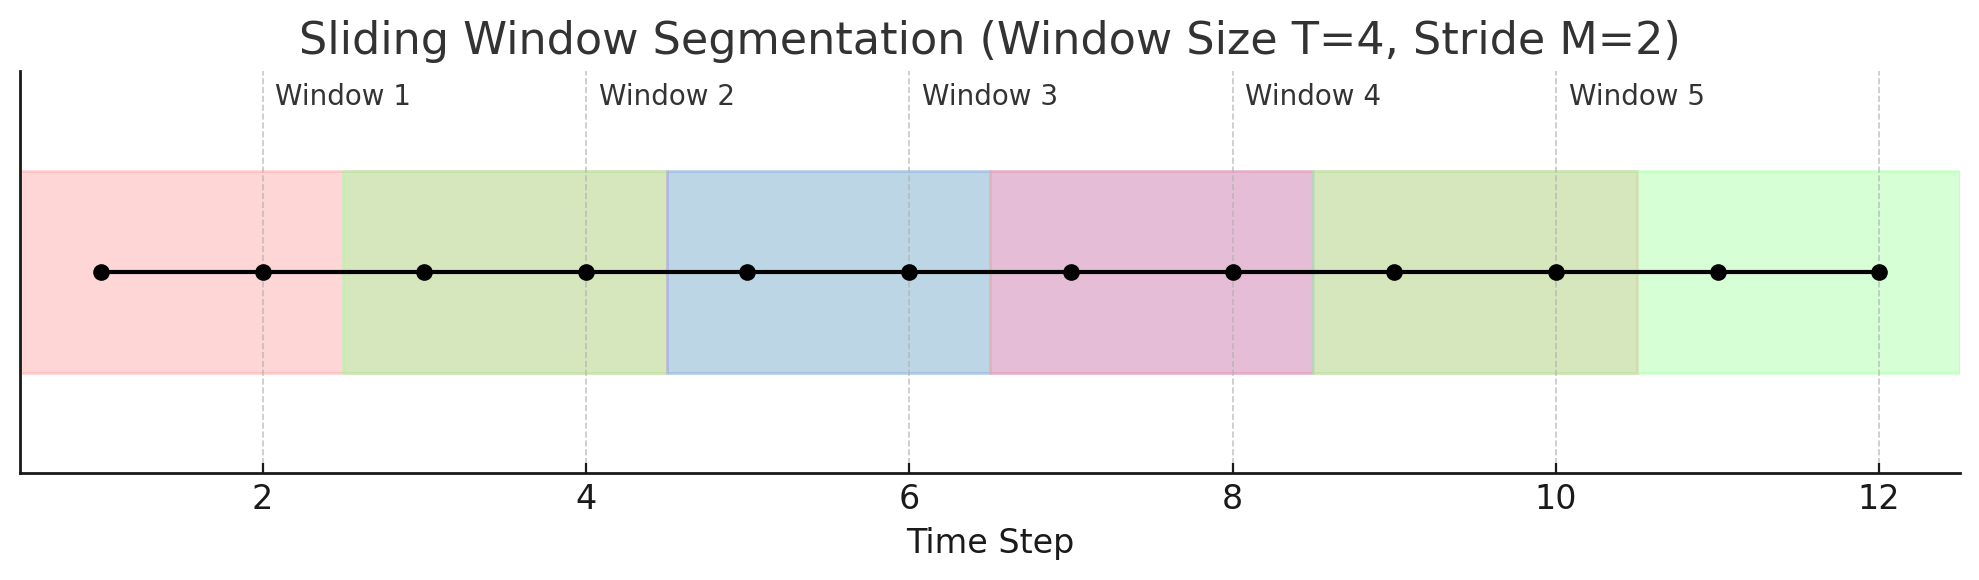

1. **入力シーケンス長を決定**: 何個の過去のデータポイントを使って将来を予測するか（例：過去20時点）
2. **ウィンドウをスライド**: 一定間隔でウィンドウを移動させながらサンプルを作成
3. **入力と出力のペア作成**: 
   - **入力 X**: [時点0, 時点1, ..., 時点19]
   - **出力 y**: 時点20

**RNN用データの次元形状:**

Kerasの`SimpleRNN`層は以下の形状の入力を期待します：

`[サンプル数, 時間ステップ数, 特徴量の数]`

- **サンプル数**: データのバッチサイズまたは全体のサンプル数
- **時間ステップ数**: 1つのサンプルに含まれる時点の数（過去何時点を見るか）
- **特徴量の数**: 各時点で観測される変数の数（単変量なら1, 多変量なら複数）

次のコードで実際に時系列データを生成し、RNN用に変換する方法を見ていきましょう。

In [ ]:
# 時系列データの生成（正弦波）
def generate_sine_wave(sample_size=1000, time_steps=50, frequency=0.1, noise=0.1):
    """正弦波の時系列データを生成する関数"""
    x = np.linspace(0, sample_size * frequency, sample_size)
    y = np.sin(x)
    
    # ノイズを追加
    if noise > 0:
        y += np.random.normal(0, noise, size=len(y))
    
    # データをスケーリング（-1から1の範囲に）
    y = y / np.max(np.abs(y))
    
    # 訓練データの準備（時系列データをスライディングウィンドウ形式に変換）
    X, Y = [], []
    for i in range(len(y) - time_steps):
        X.append(y[i:i + time_steps])
        Y.append(y[i + time_steps])
    
    # numpy配列に変換
    X = np.array(X)
    Y = np.array(Y)
    
    # RNN入力形式に変形 [samples, time_steps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, Y

# データの生成
time_steps = 20  # 過去20ポイントを使用して次のポイントを予測
X_train, y_train = generate_sine_wave(sample_size=1000, time_steps=time_steps, frequency=0.05, noise=0.05)
X_test, y_test = generate_sine_wave(sample_size=200, time_steps=time_steps, frequency=0.05, noise=0.05)

print(f"訓練データの形状: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"テストデータの形状: X_test: {X_test.shape}, y_test: {y_test.shape}")

# データの可視化
plt.figure(figsize=(12, 6))
plt.plot(y_train[:200])
plt.title('生成した正弦波データのサンプル', fontsize=14)
plt.xlabel('時間', fontsize=12)
plt.ylabel('振幅', fontsize=12)
plt.grid(True)
plt.show()

### 生成したデータの解説

上記のコードでは次のことを行いました：

1. **シンプルな正弦波の生成**:
   - 周波数0.05の正弦波を生成（ゆっくりとした波形）
   - ガウスノイズを追加して実際のデータに近づける（ノイズ強度0.05）

2. **データの正規化**:
   - データの振幅を-1〜1の範囲に正規化
   - これにより訓練が安定し、勾配消失/爆発問題を回避

3. **スライディングウィンドウ変換**:
   - 入力: 連続する20時点のデータ
   - 出力: 21時点目のデータ（次の値）

4. **RNN入力形式への変換**:
   - 3次元配列形式： [サンプル数, 時間ステップ数, 特徴量の数]
   - X_train.shape = (980, 20, 1) → 980個のサンプル、各サンプルは20時点分のデータ、各時点の特徴量は1

このようにして準備されたデータは、RNNモデルで時系列予測タスクを学習するのに適した形式になっています。

## 単純な RNN モデルの実装

TensorFlow/Kerasを使用して単純なRNNモデルを実装します。以下のステップに従います：

1. モデルのアーキテクチャ設計
2. モデルのコンパイル
3. モデルの概要確認

In [ ]:
# 単純なRNNモデルの構築
model = Sequential([
    SimpleRNN(units=64, activation='tanh', return_sequences=False, input_shape=(time_steps, 1)),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの概要
model.summary()

### モデルの解説

上記で構築したRNNモデルは以下の層で構成されています：

1. **SimpleRNN層**：
   - 64ユニット（隠れ層のサイズ）
   - tanh活性化関数（-1から1の範囲で出力）
   - return_sequences=False（最後の時間ステップの出力のみを次の層に渡す）
   - input_shape=(time_steps, 1)：入力データ形状（時間ステップ数, 特徴量の数）

2. **全結合層（Dense）**：
   - 32ユニット
   - ReLU活性化関数

3. **出力層**：
   - 1ユニット（1つの値を予測）

このモデルは、過去20時点のデータから次の1時点の値を予測するように設計されています。

## モデルのトレーニングと評価

構築したRNNモデルをトレーニングし、その性能を評価します。

In [ ]:
# モデルのトレーニング
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 訓練履歴の可視化
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='トレーニング損失')
plt.plot(history.history['val_loss'], label='検証損失')
plt.title('モデルの学習曲線', fontsize=14)
plt.xlabel('エポック', fontsize=12)
plt.ylabel('損失（MSE）', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# テストデータでモデルを評価
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"テストデータでの損失（MSE）: {test_loss:.6f}")

## モデル評価の指標と解釈

### 時系列予測の評価方法

時系列予測モデルの性能を評価する際には、複数の指標と視覚化手法を用いることが重要です。以下では、一般的な評価指標とその解釈方法について説明します：

#### 1. 主要な評価指標

- **平均二乗誤差 (MSE)**：最も基本的な指標で、予測値と実際値の差の二乗の平均
  - 値が小さいほど良いモデル
  - 外れ値に敏感（二乗するため）
  - 数式：$\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$

- **平均絶対誤差 (MAE)**：予測値と実際値の差の絶対値の平均
  - こちらも値が小さいほど良いモデル
  - MSEよりも外れ値の影響を受けにくい
  - 数式：$\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$

- **平均絶対パーセント誤差 (MAPE)**：相対的な誤差を示し、異なるスケールのデータセット間で比較可能
  - 数式：$\frac{100\%}{n}\sum_{i=1}^{n}|\frac{y_i - \hat{y}_i}{y_i}|$

#### 2. 視覚化による評価

- **実際値vs予測値プロット**：時系列に沿って実際値と予測値を重ねて表示し、モデルがパターンをどれだけ捉えているか確認
- **散布図**：実際値（x軸）と予測値（y軸）の関係を表示。完全な予測では45度線上に点が並ぶ
- **残差（誤差）プロット**：予測誤差の時間的パターンを確認。理想的には誤差はランダムで構造を持たない
- **誤差分布**：誤差のヒストグラム。理想的には平均0の正規分布に近い形状

#### 3. 交差検証の重要性

時系列データの交差検証は通常のデータとは少し異なります：
- **時間的依存性を考慮**：将来のデータで過去を予測することはできない
- **時間順序を維持**：ランダムな分割ではなく、時間順序に沿った分割が必要
- **タイムシリーズクロスバリデーション**：時間の経過と共に拡大するトレーニングセットと、それに続くテストセット

この後のコードでは、これらの評価指標と視覚化手法を用いて、RNNモデルの性能を詳細に分析します。

## 予測の可視化

トレーニングしたRNNモデルを使用して予測を行い、結果を視覚的に確認します。

In [ ]:
# テストデータでの予測
y_pred = model.predict(X_test)

# 予測結果のプロット（最初の100ポイント）
plt.figure(figsize=(14, 7))
plt.plot(y_test[:100], 'b-', label='実際の値', alpha=0.6)
plt.plot(y_pred[:100], 'r-', label='予測値', alpha=0.6)
plt.title('RNNモデルによる時系列予測', fontsize=14)
plt.xlabel('時間ステップ', fontsize=12)
plt.ylabel('値', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 予測と実際の値の散布図
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-1, 1], [-1, 1], 'r--')  # 完全一致線
plt.title('予測値 vs 実際の値', fontsize=14)
plt.xlabel('実際の値', fontsize=12)
plt.ylabel('予測値', fontsize=12)
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.grid(True)
plt.show()

# 誤差分布
errors = y_pred.flatten() - y_test
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.title('予測誤差の分布', fontsize=14)
plt.xlabel('誤差', fontsize=12)
plt.ylabel('頻度', fontsize=12)
plt.grid(True)
plt.show()

# 統計量の表示
print(f"予測誤差の平均: {np.mean(errors):.6f}")
print(f"予測誤差の標準偏差: {np.std(errors):.6f}")
print(f"平均絶対誤差 (MAE): {np.mean(np.abs(errors)):.6f}")
print(f"平均二乗誤差 (MSE): {np.mean(errors**2):.6f}")

## LSTMと比較する

SimpleRNNは長期的な依存関係を学習するのが難しいことがあります（勾配消失問題）。代わりにLSTM（Long Short-Term Memory）を使用して同じタスクに取り組み、結果を比較してみましょう。

### LSTMの基本構造：SimpleRNNの限界を克服する

**勾配消失問題：SimpleRNNの主要な課題**

SimpleRNNでは、時間ステップが進むにつれて勾配（誤差の伝播）が指数関数的に小さくなる「勾配消失問題」が発生します。これにより：
- 長期的な依存関係（前の時間ステップの情報）が学習されにくい
- モデルが最近の情報に過度に依存する
- 複雑なパターンの認識や将来予測の精度が低下する

**LSTMの主要コンポーネント**

LSTM（Long Short-Term Memory）は、この問題を解決するために特別に設計されました。主要な構成要素は：

1. **セルステート（$C_t$）**：長期記憶を保持する経路
2. **3つのゲート機構**：
   - **忘却ゲート（$f_t$）**：古い情報を忘れるかどうかを制御
   - **入力ゲート（$i_t$）**：新しい情報をどれだけ保存するかを制御
   - **出力ゲート（$o_t$）**：現在のセルステートからどれだけ出力するかを制御

**LSTMの数学的表現（簡略化）**

```
f_t = σ(Wf·[h_{t-1}, x_t] + bf)  # 忘却ゲート
i_t = σ(Wi·[h_{t-1}, x_t] + bi)  # 入力ゲート
C̃_t = tanh(Wc·[h_{t-1}, x_t] + bc)  # 候補となるセルステート
C_t = f_t * C_{t-1} + i_t * C̃_t  # セルステートの更新
o_t = σ(Wo·[h_{t-1}, x_t] + bo)  # 出力ゲート
h_t = o_t * tanh(C_t)  # 隠れ状態の出力
```

この複雑な構造により、LSTMは：
- 長期的な依存関係を効果的に学習できる
- 関連性の高い情報を長期間保持できる
- 勾配消失問題を緩和できる

これからLSTMモデルを実装し、SimpleRNNと性能を比較してみましょう。

In [ ]:
# LSTMモデルの構築
lstm_model = Sequential([
    LSTM(units=64, activation='tanh', return_sequences=False, input_shape=(time_steps, 1)),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# モデルのコンパイル
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの訓練
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# テストデータでの予測
lstm_y_pred = lstm_model.predict(X_test)

# RNNとLSTMの比較
plt.figure(figsize=(14, 10))

# 損失の比較
plt.subplot(2, 1, 1)
plt.plot(history.history['val_loss'], 'b-', label='SimpleRNN')
plt.plot(lstm_history.history['val_loss'], 'r-', label='LSTM')
plt.title('SimpleRNN vs LSTM: 検証損失', fontsize=14)
plt.xlabel('エポック', fontsize=12)
plt.ylabel('損失（MSE）', fontsize=12)
plt.legend()
plt.grid(True)

# 予測の比較
plt.subplot(2, 1, 2)
plt.plot(y_test[:100], 'k-', label='実際の値', alpha=0.7)
plt.plot(y_pred[:100], 'b-', label='SimpleRNN', alpha=0.6)
plt.plot(lstm_y_pred[:100], 'r-', label='LSTM', alpha=0.6)
plt.title('SimpleRNN vs LSTM: 予測結果', fontsize=14)
plt.xlabel('時間ステップ', fontsize=12)
plt.ylabel('値', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 両モデルのテスト損失の比較
rnn_test_loss = model.evaluate(X_test, y_test, verbose=0)
lstm_test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"SimpleRNNのテスト損失（MSE）: {rnn_test_loss:.6f}")
print(f"LSTMのテスト損失（MSE）: {lstm_test_loss:.6f}")
print(f"改善率: {((rnn_test_loss - lstm_test_loss) / rnn_test_loss) * 100:.2f}%")

## 実務での応用例

RNNとLSTMは様々な時系列データや順序データの分析・予測に使われています。実際の応用例をいくつか見てみましょう：

### 1. 金融工学

- **株価予測**：過去の株価データから将来のトレンドを予測
- **異常検出**：不正取引や異常な市場動向の検出
- **リスク評価**：将来のボラティリティやリスク水準の予測

### 2. 自然言語処理（NLP）

- **文章生成**：次の単語や文を予測・生成
- **感情分析**：テキストの感情や意図を認識
- **機械翻訳**：ある言語から別の言語へのテキスト変換

### 3. 時系列センサーデータ分析

- **工場の機器故障予測**：センサーデータから異常や故障の予兆を検知
- **エネルギー消費予測**：過去のパターンから将来のエネルギー需要を予測
- **気象予報**：気象データからの天候変化予測

### 4. 医療データ分析

- **生体信号処理**：心拍データや脳波データからの異常検出
- **病状の進行予測**：患者データから疾患の進行パターンを予測
- **医療画像の時系列解析**：MRIやCTスキャンの時系列変化の分析

### 応用のための考慮点

実際の応用では、以下の点を考慮することが重要です：

1. **データの前処理**：欠損値、外れ値、正規化など適切な前処理が結果を大きく左右
2. **特徴量エンジニアリング**：原データから有用な特徴を抽出することで予測精度が向上
3. **モデル選択**：タスクの複雑さによってSimple RNN、LSTM、GRU、Bidirectional RNNなど適切なモデルを選択
4. **ハイパーパラメータ調整**：層の数、ユニット数、学習率などを最適化
5. **評価方法**：適切な評価指標と検証方法の選択

このノートブックで学んだ基礎知識をもとに、実際の問題に取り組む際はこれらの点を考慮してモデルを構築しましょう。

## 発展的なRNNアーキテクチャ

RNNには基本的なSimple RNNとLSTM以外にも、様々な発展形があります。それぞれの特徴と利点について簡単に紹介します：

### 1. GRU（Gated Recurrent Unit）

LSTMの簡略版で、計算効率が良く、少ないパラメータ数でも高い性能を発揮します。

- **特徴**: LSTMの4つのゲートを2つ（更新ゲートとリセットゲート）に削減
- **利点**: 計算量が少なく、訓練が高速で、パラメータ数が少ないためデータが少ない場合も効果的
- **適用例**: 中短期の依存関係を持つシーケンスデータの処理

### 2. 双方向RNN（Bidirectional RNN）

過去の情報だけでなく、未来の情報も考慮したい場合に使用します。

- **特徴**: 2つのRNN（順方向と逆方向）を組み合わせて、過去と未来の両方のコンテキストを考慮
- **利点**: より豊富なコンテキスト情報を活用でき、特に文章理解などの領域で効果的
- **適用例**: 単語の品詞タグ付け、センチメント分析、テキスト分類

### 3. スタックRNN（Stacked/Deep RNN）

複数のRNN層を積み重ねることで、より複雑なパターンを学習できます。

- **特徴**: RNN層を複数層重ねる構造
- **利点**: より複雑なパターンや階層的な特徴を学習可能
- **適用例**: 複雑な時系列パターンの認識、自然言語の意味理解

### 4. Attention機構を持つRNN

長いシーケンスデータ処理での情報損失を防ぎ、関連性の高い部分に「注意」を向けます。

- **特徴**: 入力シーケンスの各位置に重み付けして、関連性の高い部分を強調
- **利点**: 長いシーケンスでも情報損失が少なく、解釈可能性が向上
- **適用例**: 機械翻訳、画像キャプション生成、長文の要約

### 5. Transformer（自己注意機構）

RNNの拡張というよりは代替モデルですが、時系列データ処理の最新技術として重要です。

- **特徴**: RNNのような逐次処理を行わず、自己注意機構（Self-Attention）でシーケンス全体を並列処理
- **利点**: 長距離依存関係の学習が容易で、並列処理による高速化が可能
- **適用例**: 大規模言語モデル（BERT、GPT等）、高精度な時系列予測

これらの発展的なモデルを理解し活用することで、より複雑な時系列問題にも対応できるようになります。まずはこのノートブックで学んだ基本的なRNNとLSTMをしっかり理解し、その後必要に応じて高度なモデルへと進んでいくことをお勧めします。

## まとめ

このノートブックでは、再帰型ニューラルネットワーク（RNN）の基本的な概念と実装方法を学びました。特に以下のポイントを理解できたはずです：

1. **RNNの基本構造**: 入力層、再帰的な隠れ層、出力層からなる構造と、その数学的表現
2. **時系列データの準備**: 時系列データをRNNモデル用に適切な形式に変換する方法
3. **RNNモデルの実装**: TensorFlow/Kerasを使ってSimpleRNNモデルを構築する方法
4. **モデルの評価**: 訓練済みモデルの性能を異なる視点から評価する方法
5. **LSTMとの比較**: 従来のRNNとLSTMの性能差

### 改善の余地

- より複雑なデータセットでの実験
- ハイパーパラメータのチューニング
- 双方向RNN（Bidirectional RNN）や注意機構（Attention mechanism）の導入
- さまざまな時系列予測タスクへの応用

RNNは時系列データや順序データを扱う上で強力なツールですが、特に長期的な依存関係を学習する場合はLSTMやGRUなどの派生アーキテクチャがより効果的であることが多いです。